<style>
.wzor {
  /* width: auto; */
  /* padding: auto; */
  border: 0.5rem solid gray;
  /* margin: 0; */
  background-color: lightgray;
}
</style>


# Modele analizy danych

### 2024/2025, semestr zimowy
Tomasz Rodak

---

## Literatura
   1. James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor,
      J. (2023). An Introduction to Statistical Learning: With
      Applications in Python.
      
      [ISLP](https://www.statlearning.com/)
   
   2. Bishop, C. M., & Nasrabadi, N. M. (2006). Pattern recognition and
      machine learning (Vol. 4, No. 4, p. 738). New York: springer. 
   
      [PRML](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/)
   
   3. Kroese, D. P., Botev, Z., Taimre, T., & Vaisman, R. (2019). Data
      science and machine learning: mathematical and statistical
      methods. CRC Press.
   
      [https://people.smp.uq.edu.au/DirkKroese/DSML/](https://people.smp.uq.edu.au/DirkKroese/DSML/)
   
   4. Hastie, T., Tibshirani, R., Friedman, J. H., & Friedman,
      J. H. (2009). The elements of statistical learning: data mining,
      inference, and prediction (Vol. 2, pp. 1-758). New York:
      springer.
   
      [https://hastie.su.domains/ElemStatLearn/](https://hastie.su.domains/ElemStatLearn/)
   
   5. Murphy, K. P. (2022). Probabilistic machine learning: an
      introduction. MIT press.
   
      [https://probml.github.io/pml-book/book1.html](https://probml.github.io/pml-book/book1.html)
   
   6. Murphy, K. P. (2023). Probabilistic machine learning: Advanced
      topics. MIT press.
   
      [https://probml.github.io/pml-book/book2.html](https://probml.github.io/pml-book/book2.html)
   
   7. Bishop, C. M., & Bishop, H (2024). Deep learning. Springer.
   
      [https://www.bishopbook.com/](https://www.bishopbook.com/)
   
   8. Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.
   
      [https://www.deeplearningbook.org/](https://www.deeplearningbook.org/)

---

## Wykład VII

ISLP, rozdział 4.4

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis as LDA,
    QuadraticDiscriminantAnalysis as QDA
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Modele generatywne w problemach klasyfikacji: LDA

W modelu regresji logistycznej obliczamy prawdopodobieństwo warunkowe $P(Y=k|x)$: prawdopodobieństwo tego, że $Y$ przyjmie wartość $k$ jeśli wiadomo, że pojawił się wektor cech $X=x$.

Można jednak postępować inaczej. Załóżmy, że $Y\in\{1,\ldots,K\}$. Wówczas:
* modelujemy rozkład cech $X$ w każdej z klas $k$, czyli znajdujemy rozkłady warunkowe $p(x|Y=k)$;
* modelujemy rozkład *a priori* występowania klas $\pi_k=P(Y=k)$;
* wykorzystujemy twierdzenie Bayesa do obliczenia rozkładu *a posteriori* $P(Y=k|x)$:


<div class="wzor">

\begin{equation*}
\begin{split}
P(Y=k|x) &= \frac{p(x|Y=k)P(Y=k)}{p(x)}\\
&= \frac{p(x|Y=k)P(Y=k)}{\sum_{l=1}^K p(x|Y=l)P(Y=l)}
\end{split}
\end{equation*}

</div>

Model ten nazywamy *modelem generatywnym*, gdyż pozwala on na generowanie wartości z rozkładu łącznego $p(x, y):=p(x|y)p(y)$. W *modelu dyskryminatywnym*, takim jak regresja logistyczna, modelujemy bezpośrednio rozkład $p(y|x)$ pomijając rozkłady warunkowe $p(x|y)$. 

Zalety modeli generatywnych:
* regresja logistyczna jest niestabilna w przypadku klas separowalnych liniowo - funkcja wiarygodności ma wtedy nieskończenie wiele maksimów lokalnych; nie jest to problem dla modeli generatywnych;
* jeśli rozkład cech $X$ jest w przybliżeniu normalny, to klasyfikator generatywny może dawać lepsze wyniki niż dyskryminatywny, w szczególności niż regresja logistyczna;
* model generatywny ma tę samą naturalną postać tak dla dwóch, jak i dla wielu klas.

Modele generatywne są bardziej złożone obliczeniowo niż modele dyskryminatywne i wymagają spełnienia dodatkowych założeń. Modelowanie prawdopodobieństw a priori $P(Y=k)$ jest zwykle proste. Jeśli nie mamy żadnych dodatkowych informacji o rozkładzie klas, to przyjmujemy po prostu, że prawdopobieństwo a priori wystąpienia klasy $k$ jest równe częstości występowania tej klasy w zbiorze uczącym:

<div class="wzor">

\begin{equation*}
\begin{split}
P(Y=k) &= \frac{\text{liczba obserwacji klasy }k}{\text{liczba wszystkich obserwacji}}\\
&=\frac{1}{n}\sum_{i=1}^n I(y_i=k)
\end{split}
\end{equation*}

</div>

Wyznaczenie rozkładów cech w klasach $p(x|Y=k)$ jest zwykle znacznie trudniejsze i wymaga wprowadzenia dodatkowych założeń. W zależności od tego jakie założenia przyjmiemy, otrzymamy różne modele generatywne. Dalej omówimy trzy takie modele: *Linear Discriminant Analysis*, *Quadratic Discriminant Analysis* oraz *Naive Bayes*.

### Linear Discriminant Analysis (LDA) dla $p=1$

Dla uproszczenia zakładamy, że $p=1$, czyli mamy tylko jedną cechę $X$. Rozkład $P(Y=k)$ wyznaczamy jak wyżej. Natomiast o rozkładach $p(x|Y=k)$ zakładamy, że są one normalne o jednakowych wariancjach $\sigma^2$ i różnych średnich $\mu_k$: 

<div class="wzor">

\begin{equation*}
p(x|Y=k)\sim N(\mu_k, \sigma^2)
\end{equation*}

</div>

Gęstość rozkładu normalnego $N(\mu, \sigma^2)$ jest dana wzorem:

<div class="wzor">

\begin{equation*}
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
\end{equation*}

</div>

W konsekwencji, rozkład warunkowy $p(x|Y=k)$ ma postać:

<div class="wzor">

\begin{equation*}
p(x|Y=k) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x-\mu_k)^2}{2\sigma^2}\right).
\end{equation*}

</div>

Oznacza to w szczególności, że $X$ jest zmienną losową ciągłą.

Wówczas:

\begin{equation}
\begin{split}
P(Y=k|x) &= \frac{p(x|Y=k)P(Y=k)}{p(x)}\\ 
&= \frac{p(x|Y=k)P(Y=k)}{\sum_{l=1}^K p(x|Y=l)P(Y=l)}\\
&= \frac{\exp\left(-\frac{(x-\mu_k)^2}{2\sigma^2}\right)P(Y=k)}{\sum_{l=1}^K \exp\left(-\frac{(x-\mu_l)^2}{2\sigma^2}\right)P(Y=l)}.
\end{split} \tag{LDA}
\end{equation}

Klasę $\hat{y}$ pod warunkiem wystąpienia obserwacji $x$ wybieramy zgodnie z regułą klasyfikatora Bayesa:

\begin{equation*}
\hat{y} = \operatorname{argmax}_{k\in\{1,\ldots,K\}} P(Y=k|x).
\end{equation*}

Dla ustalonego $x$ mianownik we wzorze (LDA)
jest stały, więc wystarczy maksymalizować licznik. Biorąc logarytm licznika widzimy, że nierówność

\begin{equation*}
P(Y=k|x) > P(Y=l|x) 
\end{equation*}

jest kolejno równoważna nierównościom:

\begin{align*}
\log P(Y=k) - \frac{(x-\mu_k)^2}{2\sigma^2} &> \log P(Y=l) - \frac{(x-\mu_l)^2}{2\sigma^2}\quad\iff\\
\log P(Y=k) + \frac{\mu_k}{\sigma^2}x - \frac{\mu_k^2}{2\sigma^2} &> \log P(Y=l) + \frac{\mu_l}{\sigma^2}x - \frac{\mu_l^2}{2\sigma^2}\quad\iff\\
x &> \frac{\mu_k+\mu_l}{2} + \frac{\sigma^2}{\mu_k-\mu_l}\log \frac{P(Y=l)}{P(Y=k)}.
\end{align*}

Dzięki założeniu, że wariancja jest taka sama dla wszystkich klas, składniki drugiego stopnia względem $x$ znikają. W konsekwencji granice decyzyjne między klasami znajdują się w punktach

\begin{equation*}
x = \frac{\mu_k+\mu_l}{2} + \frac{\sigma^2}{\mu_k-\mu_l}\log \frac{P(Y=l)}{P(Y=k)}.
\end{equation*}

gdzie $k,l$ spełniają warunek $P(Y=l|x) = P(Y=k|x) \geqslant P(Y=m|x)$ dla wszystkich $m\neq k,l$. W szczególności, jeśli $K=2$, to granica decyzyjna wypada w punkcie

\begin{equation*}
x = \frac{\mu_1+\mu_2}{2} + \frac{\sigma^2}{\mu_1-\mu_2}\log \frac{P(Y=2)}{P(Y=1)}.
\end{equation*}

Jeśli dodatkowo prawdoopodobieństwa a priori są równe $P(Y=1)=P(Y=2)=1/2$, to:

\begin{equation*}
x = \frac{\mu_1+\mu_2}{2}.
\end{equation*}

Funkcje

\begin{equation*}
\delta_k(x) = \log P(Y=k) + \frac{\mu_k}{\sigma^2}x - \frac{\mu_k^2}{2\sigma^2}
\end{equation*}

nazywamy *funkcjami dyskryminacyjnymi* (ang. *discriminant functions*). Użycie tych funkcji pozwala na zapisanie klasyfikatora LDA w postaci dyskryminatywnej:

\begin{equation*}
\hat{y} = \operatorname{argmax}_{k\in\{1,\ldots,K\}} \hat\delta_k(x),
\end{equation*}

gdzie

\begin{equation*}
\hat\delta_k(x) = \log\hat{P}(Y=k) + \frac{\hat{\mu}_k}{\hat{\sigma}^2}x - \frac{\hat{\mu}_k^2}{2\hat{\sigma}^2}.
\end{equation*}

In [3]:
n = 1000
k1 = 800
k2 = n - k1
mu1, mu2 = -10, 12
sigma = 3
x1 = np.random.normal(mu1, sigma, k1)
x2 = np.random.normal(mu2, sigma, k2)
x = np.concatenate((x1, x2))
y = np.concatenate((np.zeros(k1), np.ones(k2)))

In [4]:
lda = LDA(store_covariance=True)
lda.fit(x.reshape(-1, 1), y)
mu1_hat, mu2_hat = lda.means_
sigma_hat = np.sqrt(lda.covariance_)
print(mu1_hat, mu2_hat, sigma_hat)

[-10.02006132] [12.03057661] [[3.01250324]]


In [5]:
decision_boundary = (mu1_hat + mu2_hat)/2 + np.log(k1 / k2)*sigma_hat**2/(mu1_hat - mu2_hat)
decision_boundary = decision_boundary[0, 0]
print(decision_boundary)

0.434713380716093


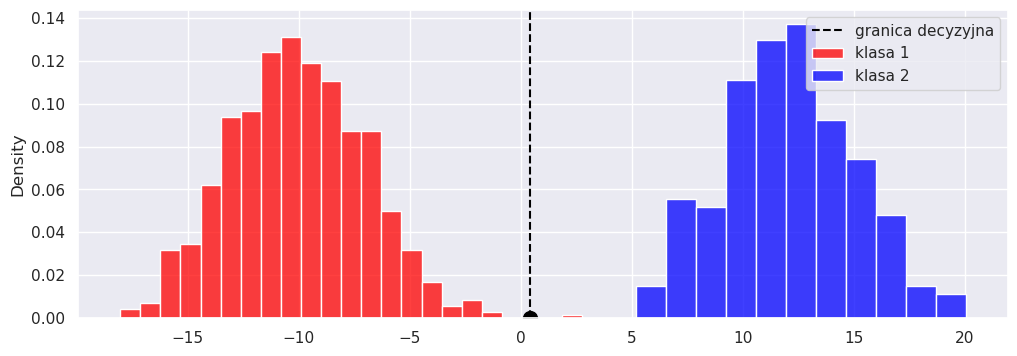

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(x1, ax=ax, color='red', stat='density', label='klasa 1')
sns.histplot(x2, ax=ax, color='blue', stat='density', label='klasa 2')
ax.axvline(decision_boundary, color='black', linestyle='--', label='granica decyzyjna')
ax.scatter(decision_boundary, 0, color='black', marker='o', s=100)
ax.legend();

#### Szacowanie parametrów modelu LDA

Prawdopodobieństwa a priori szacujemy na podstawie częstości występowania klas w zbiorze uczącym

\begin{equation*}
\hat{P}(Y=k) = \frac{n_k}{n},
\end{equation*}

gdzie $n_k$ oznacza liczbę obserwacji klasy $k$ w zbiorze uczącym.
Parametry $\mu_k$ i $\sigma^2$ szacujemy metodą największej wiarygodności. Można pokazać, że:

\begin{align*}
\hat{\mu}_k &= \frac{1}{n_k}\sum_{i:y_i=k} x_i,\\
\hat{\sigma}^2 &= \frac{1}{n-K}\sum_{k=1}^K\sum_{i:y_i=k} (x_i-\hat{\mu}_k)^2.
\end{align*}

### Linear Discriminant Analysis (LDA) dla $p>1$

W przypadku gdy $p>1$ zakładamy, że rozkłady $p(x|Y=k)$ są wielowymiarowymi rozkładami normalnymi o jednakowych macierzach kowariancji $\Sigma$ i różnych wektorach średnich $\mu_k$:

<div class="wzor">

\begin{equation*}
p(x|Y=k)\sim N(\mu_k, \Sigma).
\end{equation*}

</div>

Gęstość wielowymiarowego rozkładu normalnego $N(\mu, \Sigma)$ jest dana wzorem:

<div class="wzor">

\begin{equation*}
f(x) = \frac{1}{(2\pi)^{p/2}|\Sigma|^{1/2}}\exp\left(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right)
\end{equation*}

</div>

W konsekwnecji, rozkład warunkowy $p(x|Y=k)$ ma postać:

<div class="wzor">

\begin{equation*}
p(x|Y=k) = \frac{1}{(2\pi)^{p/2}|\Sigma|^{1/2}}\exp\left(-\frac{1}{2}(x-\mu_k)^T\Sigma^{-1}(x-\mu_k)\right).
\end{equation*}

</div>

Funkcje dyskryminacyjne mają w tym przypadku postać:

\begin{equation*}
\delta_k(x) = x^T\Sigma^{-1}\mu_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + \log P(Y=k).
\end{equation*}

Znów dzięki założeniu, że macierz kowariancji jest taka sama dla wszystkich klas, składniki drugiego stopnia względem $x$ znikają. W konsekwencji granice decyzyjne między klasami $\delta_k(x) = \delta_l(x)$ są fragmentami hiperpłaszczyzn:

\begin{equation*}
x^T\Sigma^{-1}\mu_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + \log P(Y=k) = x^T\Sigma^{-1}\mu_l - \frac{1}{2}\mu_l^T\Sigma^{-1}\mu_l + \log P(Y=l).
\end{equation*}

Estymacja parametrów w tym przypadku jest analogiczna do przypadku $p=1$, choć wzory są bardziej skomplikowane z powodu obecności macierzy kowariancji $\Sigma$ zamiast wariancji $\sigma^2$ i wektorów średnich $\mu_k\in\mathbb{R}^p$ zamiast liczb $\mu_k\in\mathbb{R}$. Szczegóły można znaleźć w [PRML, rozdział 4.2.2 ($K=2$)](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/).

Analogicznie jak dla $p=1$, klasyfikator LDA dla $p>1$ można zapisać w postaci dyskryminatywnej:

\begin{equation*}
\hat{y} = \operatorname{argmax}_{k\in\{1,\ldots,K\}} \hat\delta_k(x).
\end{equation*}

#### LDA na zbiorze `Default`

In [7]:
df = pd.read_csv('datasets/Default.csv')
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [8]:
y = df['default'].map({'No': 0, 'Yes': 1})
X = df[['balance', 'income']].copy()
X['student'] = df['student'].map({'No': 0, 'Yes': 1})

In [9]:
lda = LDA(store_covariance=True)
lda.fit(X, y)

LinearDiscriminantAnalysis(store_covariance=True)

In [10]:
confusion_matrix(y, lda.predict(X))

array([[9645,   22],
       [ 254,   79]])

In [11]:
lda.score(X, y) # dokładność klasyfikacji

0.9724

Powyższa macierz jest *macierzą pomyłek* (*confusion matrix*). Wiersze odpowiadają prawdziwym klasom, kolumny przewidywanym klasom. Element $i,j$ macierzy to liczba obserwacji klasy $i$, które zostały zaklasyfikowane do klasy $j$. W idealnym klasyfikatorze macierz ta byłaby macierzą diagonalną.

Zatem:
* 9645 osób nie zaciągnęło kredytu i zostało zaklasyfikowanych do klasy "niezaciągających kredytu"; prawdziwie ujemna (TN, *true negative*): klasyfikator poprawnie przewidział, że cecha nie wystąpi;
* 22 osoby nie zaciągnęły kredytu, ale zostały zaklasyfikowane do klasy "zaciągających kredyt"; fałszywie dodatnia (FP, *false positive*): klasyfikator błędnie przewidział, że cecha wystąpi;
* 254 osób zaciągnęło kredyt i zostało zaklasyfikowanych do klasy "niezaciągających kredytu"; fałszywie ujemna (FN, *false negative*): klasyfikator błędnie przewidział, że cecha nie wystąpi;
* 79 osób zaciągnęło kredyt i zostało zaklasyfikowanych do klasy "zaciągających kredyt"; prawdziwie dodatnia (TP, *true positive*): klasyfikator poprawnie przewidział, że cecha wystąpi.

Macierz pomyłek można wykorzystać do obliczenia wielu miar jakości klasyfikatora. Przykładowo:
* *accuracy* (dokładność) - stosunek liczby poprawnych klasyfikacji do liczby wszystkich klasyfikacji: $(TP+TN)/(TP+TN+FP+FN)$; w naszym przypadku: $(9645+79)/(9645+22+254+79) = 0.9736$; odpowiada na pytanie: jak często klasyfikator poprawnie przewiduje klasę obserwacji;
* *precision* (precyzja) - stosunek liczby klasyfikacji prawdziwie dodatnich do liczby wszystkich klasyfikacji dodatnich: $TP/(TP+FP)$; w naszym przypadku: $79/(79+22) = 0.7822$; odpowiada na pytanie: jak często przewidywania klasy dodatniej są poprawne;
* *specificity* (swoistość) - stosunek liczby klasyfikacji prawdziwie ujemnych do liczby wszystkich obserwacji ujemnych: $TN/(TN+FP)$; w naszym przypadku: $9645/(9645+22) = 0.9977$; odpowiada na pytanie: jak często klasyfikator poprawnie przewiduje w klasie ujemnej;
* *recall* (czułość) - stosunek liczby klasyfikacji prawdziwie dodatnich do liczby wszystkich obserwacji dodatnich: $TP/(TP+FN)$; w naszym przypadku: $79/(79+254) = 0.2373$; odpowiada na pytanie: jak często klasyfikator poprawnie przewiduje w klasie dodatniej;

Widzimy, że nasz model ma bardzo wysoką dokładność i swoistość. Oznacza to, że przeważająca liczba obserwacji została poprawnie zaklasyfikowana oraz, że w klasie ujemnej (niezaciągających kredytu) przeważająca liczba obserwacji również została poprawnie zaklasyfikowana. Niestety, naiwny model przewidujący "niezaciąganie kredytu" dla wszystkich obserwacji ma dokładność $9667/10000=0.9667$, a swoistość 1 (nie popełnia żadnych błędów w klasie ujemnej). Zatem nasz model jest tylko nieznacznie lepszy od naiwnego modelu. Powodem tego stanu rzeczy jest nierównomierna liczba obserwacji w klasach. W zbiorze uczącym jest 9667 obserwacji klasy "niezaciągających kredytu" i tylko 333 obserwacje klasy "zaciągających kredyt". 

Precyzja równa 0.7822 oznacza, że jeśli model przewiduje, że osoba zaciągnie kredyt, to w 78.22% przypadków jego przewidywanie jest poprawne. Czułość równa 0.2373 oznacza, że jeśli osoba zaciągnie kredyt, to jedynie w 23.73% przypadków model to poprawnie przewidzi. Oznacza to, że wśród osób, które zaciągnęły kredyt, model myli się w 76.27% przypadków, a zatem bardzo często.
W praktyce, w zależności od celu klasyfikacji, możemy chcieć zwiększyć precyzję kosztem czułości lub odwrotnie zmieniając próg decyzyjny. 

Dla progu $0.2$ obserwację $X=x$ przypisujemy do klasy "zaciągających kredyt", gdy

\begin{equation*}
P(\text{default}=\text{"Yes"}|X=x) > 0.2.
\end{equation*}

Otrzymujemy wówczas macierz pomyłek:

In [12]:
threshold = 0.2
y_pred = lda.predict_proba(X)[:, 1] > threshold
confusion_matrix(y, y_pred)

array([[9435,  232],
       [ 140,  193]])

Teraz liczba poprawnych przewidywań w klasie dodatniej jest równa $193/(193+140)=0.5793$, czyli 58% (wcześniej było to 23.73%). Z drugiej strony, liczba poprawnych przewidywań w klasie ujemnej spadła do $9449/(9449+218)=0.9771$, czyli 98% (wcześniej było to 99.77%). 

Ocenę modelu dla różnych progów decyzyjnych można przedstawić na wykresie ROC: na osi odciętych znajduje się *false positive rate* (FPR, 1-swoistość), czyli klasyfikacje dodatnie w klasie ujemnej: $FPR=FP/(FP+TN)$; na osi rzędnych znajduje się *true positive rate* (TPR, czułość), czyli klasyfikacje dodatnie w klasie dodatniej: $TPR=TP/(TP+FN)$. Dla naszego modelu wykres ROC wygląda następująco (na niebiesko fragment między progiem 0.2 a 0.5):

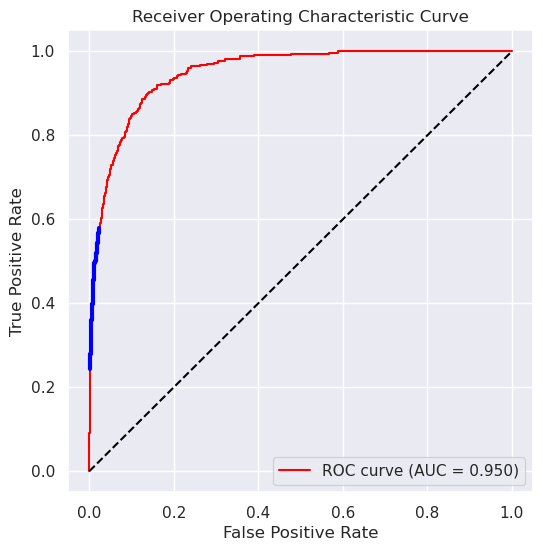

In [13]:
# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y, lda.predict_proba(X)[:, 1])
auc = roc_auc_score(y, lda.predict_proba(X)[:, 1])

thr1 = 0.2
thr2 = 0.5
fpr12, tpr12 = fpr[(thr1 < thresholds) & (thresholds < thr2)], tpr[(thr1 < thresholds) & (thresholds < thr2)]

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, color='red', label=f'ROC curve (AUC = {auc:.3f})')
ax.plot(fpr12, tpr12, color='blue', lw=3)
ax.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic Curve')
ax.legend();

Dla klasyfikatora przewidującego losowo wykres ROC jest prostą łączącą punkty $(0,0)$ i $(1,1)$. Im wykres ROC znajduje się bliżej lewego górnego rogu, tym lepszy jest klasyfikator. 

Punkt (0,0) odpowiada klasyfikatorowi przypiującemu wszystkim obserwacjom klasę ujemną. Punkt (1,1) odpowiada klasyfikatorowi przypisującemu wszystkim obserwacjom klasę dodatnią. 